# Experiment 3aii: Random Isotropic Perturbations at Thought Anchors (KL vs. ε)

This notebook mirrors Experiment 3a's setup but replaces targeted steering with random isotropic perturbations in the residual stream at selected layers.

Protocol:
- Use the same anchor/counterfactual prompt pairs as in 3a (from the annotated dataset).
- At the token just before the anchor, sample random unit directions in hidden space.
- Scale each perturbation by ε times the RMS of the (unperturbed) residual at that token/layer.
- Compute KL divergence over the anchor chunk next-token distributions vs. the unperturbed run.
- Plot KL vs. ε, averaging over random directions (and examples).


In [7]:
import os, json, math, random, gc
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from utils import load_model_and_vectors, split_solution_into_chunks, get_char_to_token_map

# Parameters (keep consistent with 3a where possible)
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
max_examples = 8  # subset for a quick run; increase as needed
selected_layers = None  # e.g., [24, 26, 28]; None = use last layer only
epsilons = 10*[0.0, 0.25, 0.5, 1.0, 2.0]  # multiples of RMS
n_directions = 8  # random directions per epsilon
seed = 42
random.seed(seed); torch.manual_seed(seed)

# Resolve device in the same way as other experiments
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'cuda'

In [8]:
# Load model and tokenizer (no features needed)
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
# Ensure model is in eval mode to disable dropout and reduce memory use
model.eval()
# Disable grad globally in case other code accidentally enables it
torch.set_grad_enabled(False)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
hidden_size = model.config.hidden_size
num_layers = model.config.num_hidden_layers
if selected_layers is None:
    selected_layers = [num_layers - 1]  # last layer default
selected_layers

No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


[27]

In [9]:
from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
cwd = Path.cwd()
repo_root = next((p for p in [cwd] + list(cwd.parents) if (p / 'generated_data').exists()), cwd)
# Load annotated dataset produced by Experiment 2
model_tag = model_name.replace('/', '-')
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
assert annotated_path.exists(), f'Missing annotated dataset: {annotated_path}'
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
# Filter to examples with an anchor sentence
examples = [ex for ex in annotated if ex.get('thought_anchor_sentence')]
if max_examples is not None:
    examples = examples[:max_examples]
len(examples)

2

In [10]:
def find_anchor_token_span(full_text: str, cot_text: str, anchor_sentence: str):
    """Locate token-span [start, end) of the anchor sentence within full_text.
    First try char-to-token mapping; fallback to sub-token sequence search.
    Returns (start_idx, end_idx, think_start_idx_char).
    """
    think_start = full_text.find('<think>')
    if think_start < 0:
        think_start = 0
    # Char mapping approach
    try:
        offsets = tokenizer.encode_plus(full_text, return_offsets_mapping=True)['offset_mapping']
    except Exception:
        offsets = None
    if offsets:
        anchor_char = cot_text.find(anchor_sentence)
        if anchor_char >= 0:
            # Map cot offset to full_text by adding think_start and '<think>' length if applicable
            # We assume cot_text appears after '<think>' in full_text
            # Find the first occurrence of cot_text in full_text to establish base
            cot_in_full = full_text.find(cot_text[:max(1, min(20, len(cot_text)))])
            base_char = cot_in_full if cot_in_full >= 0 else think_start
            start_char = base_char + anchor_char
            end_char = start_char + len(anchor_sentence) - 1
            # Build char->token map
            char_to_tok = {}
            for ti, (s,e) in enumerate(offsets):
                for cp in range(s, e):
                    char_to_tok[cp] = ti
            ts = char_to_tok.get(start_char, None)
            te = char_to_tok.get(end_char, None)
            if ts is not None and te is not None and ts < te:
                return ts, te+1, think_start
    # Fallback: sub-token match
    ids_full = tokenizer(full_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    ids_anchor = tokenizer(anchor_sentence, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    # Search after think_start region by limiting to suffix tokens
    # Convert char think_start to token index by approximate scan
    approx_ts = 0
    try:
        prefix = tokenizer(full_text[:think_start], return_tensors='pt', add_special_tokens=False)['input_ids'][0]
        approx_ts = int(prefix.shape[-1])
    except Exception:
        approx_ts = 0
    hay = ids_full[approx_ts:]
    def find_subseq(h, n):
        L, M = len(h), len(n)
        for i in range(max(0, L-M+1)):
            if h[i:i+M] == n:
                return i
        return -1
    pos = find_subseq(hay, ids_anchor)
    if pos >= 0:
        s = approx_ts + pos
        return s, s+len(ids_anchor), think_start
    return None, None, think_start

def build_full_text(ex):
    # Use the exact prompt + generated text saved upstream for consistency
    base = ex.get('raw_response') or ''
    # If raw_response is missing, reconstruct minimal input: prompt + think + cot
    if not base:
        prompt = ex.get('model_input_prompt') or ''
        cot = ex.get('cot') or ''
        base = prompt + cot
    return base

def kl_between_logits(logits_p, logits_q):
    # logits_*: [T, V]
    logp = F.log_softmax(logits_p, dim=-1)
    logq = F.log_softmax(logits_q, dim=-1)
    p = logp.exp()
    kl = (p * (logp - logq)).sum(dim=-1)  # [T]
    return float(kl.mean().item())

def unit_random_direction(dim, device, dtype):
    v = torch.randn(dim, device=device, dtype=torch.float32)
    v = v / (v.norm() + 1e-12)
    return v.to(dtype)

In [11]:
results = {layer: {float(eps): [] for eps in epsilons} for layer in selected_layers}

# Run evaluation with no_grad to avoid storing gradients
with torch.no_grad():
    for idx, ex in enumerate(examples, start=1):
        question_preview = (ex.get('prompt','') or '').replace('\n', ' ')[:80]
        anchor_sentence = ex.get('thought_anchor_sentence') or ''
        cot_text = ex.get('cot') or ''
        full_text = build_full_text(ex)

        # Encode up to at least end of anchor sentence to compute logits teacher-forced
        tok = tokenizer(full_text, return_tensors='pt', add_special_tokens=False)
        ids_full = tok['input_ids'].to(model.device)
        attn_full = (ids_full != tokenizer.pad_token_id).long().to(model.device)

        # Locate anchor token span and choose the token just before anchor
        ts, te, think_char = find_anchor_token_span(full_text, cot_text, anchor_sentence)
        if ts is None or te is None or ts <= 0:
            print(f'[skip] could not locate anchor span for example {idx}: {question_preview}')
            continue
        token_before = ts - 1

        # Baseline trace: capture logits and per-layer RMS at token_before
        with model.trace({
            'input_ids': ids_full,
            'attention_mask': attn_full,
        }) as tracer:
            # Save layer outputs for RMS and final logits
            resid_saves = []
            for L in selected_layers:
                resid_saves.append(model.model.layers[L].output[0].save())
            logits_base = model.lm_head.output.save()

        # Move baseline logits to CPU and free tracer saves
        logits_base = logits_base[0, ts:te, :].detach().to(torch.float32).cpu()  # [T,V]
        rms_by_layer = {}
        for L, rs in zip(selected_layers, resid_saves):
            # Move only the vector we need to CPU and compute RMS there
            h_cpu = rs[0, token_before, :].detach().to(torch.float32).cpu()
            rms = float((h_cpu.pow(2).mean().sqrt().item()))
            rms_by_layer[L] = rms if math.isfinite(rms) and rms > 0 else 1e-3
            # free GPU handle
            try:
                del rs
            except Exception:
                pass
        # free list and collect
        try:
            del resid_saves
        except Exception:
            pass
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # For each layer, run perturbations for each epsilon and average KL over directions
        for L in selected_layers:
            rms = rms_by_layer[L]
            dtype = torch.bfloat16 if hasattr(model, 'dtype') and str(model.dtype) == 'torch.bfloat16' else torch.bfloat16
            for eps in epsilons:
                kls = []
                if eps == 0.0:
                    # KL(base || base) = 0 for reference
                    results[L][float(eps)].append(0.0)
                    continue
                for _ in range(n_directions):
                    v = unit_random_direction(hidden_size, model.device, dtype)
                    delta = (eps * rms) * v
                    with model.trace({
                        'input_ids': ids_full,
                        'attention_mask': attn_full,
                    }) as tracer:
                        # Inject at the single position token_before
                        model.model.layers[L].output[0][0, token_before, :] += delta
                        logits_p = model.lm_head.output.save()

                    # move logits to CPU and free tracer
                    logits_p = logits_p[0, ts:te, :].detach().to(torch.float32).cpu()
                    try:
                        del tracer
                    except Exception:
                        pass
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                    kl = kl_between_logits(logits_p, logits_base)
                    kls.append(kl)
                if kls:
                    results[L][float(eps)].append(float(sum(kls)/len(kls)))

# Aggregate per-layer averages across examples
summary = {L: {eps: (sum(vals)/len(vals) if vals else 0.0) for eps, vals in eps_map.items()} for L, eps_map in results.items()}
summary

{27: {0.0: 0.0, 0.25: 0.0, 0.5: 0.0, 1.0: 0.0, 2.0: 0.0}}

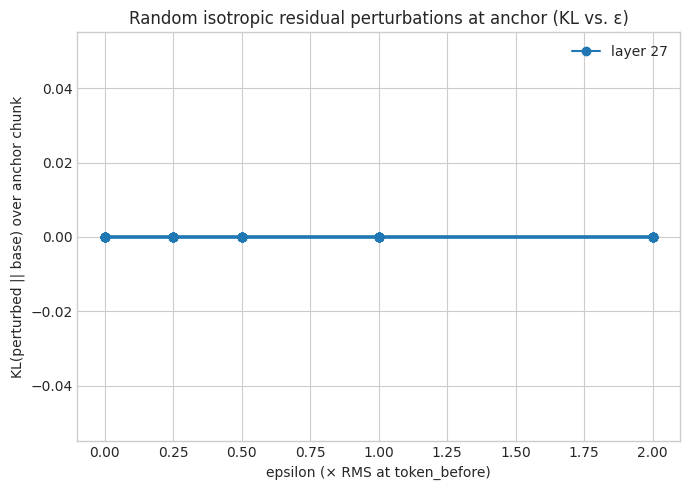

In [12]:
# Plot KL vs. epsilon per selected layer
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7,5))
for L in selected_layers:
    xs = [float(e) for e in epsilons]
    ys = [summary[L].get(float(e), 0.0) for e in epsilons]
    ax.plot(xs, ys, marker='o', label=f'layer {L}')
ax.set_xlabel('epsilon (× RMS at token_before)')
ax.set_ylabel('KL(perturbed || base) over anchor chunk')
ax.set_title('Random isotropic residual perturbations at anchor (KL vs. ε)')
ax.legend()
plt.tight_layout()
plt.show()